In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
        }

vocs = VOCS(
    variables = {
        "AWA:Bira3Ctrl:Ch03":[-1.0,1.0],
        "AWA:Drive:DT8H_B_S:Ctrl":[-2.1,2.1]

    },
    constraints = IMAGE_CONSTRAINTS,
    observables = ["Cx"],
)

In [3]:
vocs.variable_names

['AWA:Bira3Ctrl:Ch03', 'AWA:Drive:DT8H_B_S:Ctrl']

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=False, visualize=False
)

In [5]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(2.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [6]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
from copy import deepcopy
sys.path.append("../bax/")

from bax_alignment import ScipyBeamAlignment
covar_module = PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1])
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Cx': scaled_covar_module}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

algo = ScipyBeamAlignment(
    meas_dims=[0], 
    n_samples=10, 
    x_key='Cx'
)

generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo,
    n_interpolate_points=5,
)

#generator = BayesianExplorationGenerator(
#    vocs=vocs, 
#    gp_constructor=model_constructor, 
#)

generator.numerical_optimizer.max_time = 10.0


In [7]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, strict=False,) 
         #dump_file="small_discrepancy_initial_sampling_lower_noise_prior.yml")

In [8]:
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: small_discrepancy_initial_sampling_lower_noise_prior.yml
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  algorithm:
    n_samples: 10
  algorithm_results_file: null
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: 5
  n_monte_carlo_samples: 128
  name: BAX
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: false
vocs:
  constants: {}
  constraints:
  

In [9]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)
# get small region around current point to sample
#random_sample_region = get_local_region(current_value, X.vocs, fraction=0.5)

def init_step_pattern(vocs, start_point, step_sizes):
    """
    Function that produces an list of input dicts with a starting point and subsequent single-dimensional
    steps in each variable specified by list of step_sizes.
   
    Inputs:
        vocs: the vocs object from xopt
        start_point: a list of length len(vocs.variable_names) specifying the initial point to evaluate.
                    Values must be ordered according to the order of variables given by vocs.variable_names.
        step_sizes: a list of length len(vocs.variable_names) specifying the step sizes to take for the
                    subsequent evaluations. Values must be ordered according to the order of variables given
                    by vocs.variable_names. Positive step sizes correspond to steps in positive direction.
                    Negative step sizes will be in the negative direction.
    """
    input_dicts = [{name:val for name, val in zip(vocs.variable_names, start_point)}]
    for i in range(len(vocs.variable_names)):
        for j in [1,2]:
            step = {name:val for name, val in zip(vocs.variable_names, start_point)}
            step[vocs.variable_names[i]] = start_point[i] + step_sizes[i]*j
            input_dicts += [step]
    return input_dicts


#input_dicts = init_step_pattern(vocs, [0, 0.5], [0.25, 0.5])
#print(input_dicts)
#X.evaluate_data(input_dicts)

# create a mesh
n_samples = 2
xx = np.meshgrid(
    np.linspace(-0.5,0.5,2),
    np.linspace(-0.25,-0.1,2)
)
pts = np.vstack([ele.flatten() for ele in xx])
print(pts)
X.evaluate_data({"AWA:Bira3Ctrl:Ch03":pts[0],"AWA:Drive:DT8H_B_S:Ctrl":pts[1]})

#X.random_evaluate(2)#, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch03': 1.0, 'AWA:Drive:DT8H_B_S:Ctrl': 0.06358450500000226}
[[-0.5   0.5  -0.5   0.5 ]
 [-0.25 -0.25 -0.1  -0.1 ]]


CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:62521, Ignored: 192.168.0.2:62521"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Mar 14 2024 13:06:14.956249294
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:62521, Ignored: awa3.hep.anl.gov:62521"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Mar 14 2024 13:06:14.957494461
..................................................................


fitting image
138.25712619339546 155.0
fitting image
132.484224359178 155.0
fitting image
150.44976437266547 155.0
fitting image
152.08286495951958 155.0


,AWA:Bira3Ctrl:Ch03,AWA:Drive:DT8H_B_S:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,-0.5,-0.25,138.257126,129.295839,5.155639,22.719571,-57.237055,6566483.0,6.817333,-16.742874,-25.704161,30.676175,1.710440e+09,3.376132,False
1,0.5,-0.25,132.484224,175.715247,22.849140,4.651328,-65.240796,6534829.0,6.815234,-22.515776,20.715247,30.595451,1.710440e+09,3.272410,False
2,-0.5,-0.10,150.449764,127.100080,5.097355,21.827415,-65.761381,6559271.0,6.816856,-4.550236,-27.899920,28.268537,1.710440e+09,3.330467,False
3,0.5,-0.10,152.082865,175.061156,24.342512,4.404299,-79.360792,6611077.0,6.820272,-2.917135,20.061156,20.272140,1.710440e+09,3.275990,False


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:337: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1691.)
  Lnn = torch.cholesky(K.to_dense())
/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:194: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse 

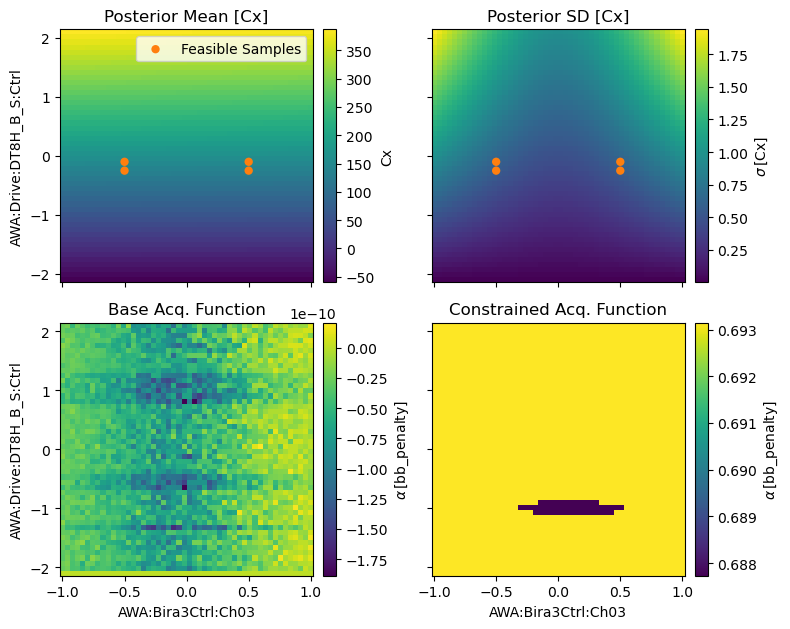

In [10]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


In [11]:
for i in range(5):
    X.step()

fitting image
117.2402445642809 155.0
fitting image
83.56395835902768 155.0
fitting image
52.639711888299644 155.0
fitting image
26.522058000714974 155.0
fitting image
5.49168043944797 155.0
fitting image
43.30060566881087 155.0
fitting image
77.71358639356416 155.0
fitting image
106.04326441652508 155.0
fitting image
129.4734165831914 155.0
fitting image
148.38711592495244 155.0
fitting image
147.49962529062003 155.0
fitting image
147.83964050876892 155.0
fitting image
148.97723948887153 155.0
fitting image
146.3977983689624 155.0
fitting image
149.98501228812356 155.0
fitting image
148.35766201650998 155.0
fitting image
150.19266884573656 155.0
fitting image
150.4637911666661 155.0
fitting image
148.0658717577035 155.0
fitting image
147.37798603712977 155.0
fitting image
150.81665730423185 155.0
fitting image
148.21866699935262 155.0
fitting image
148.05976686425635 155.0
fitting image
147.50391069033626 155.0
fitting image
148.20544170820781 155.0


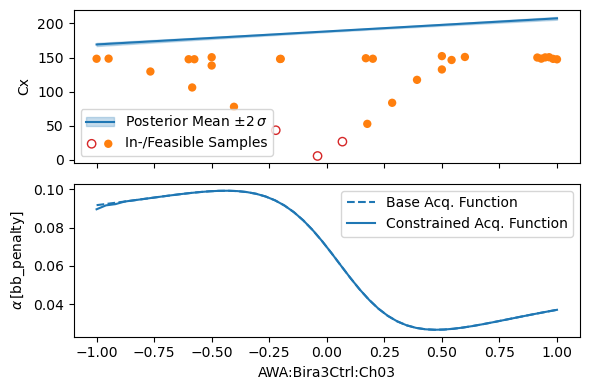

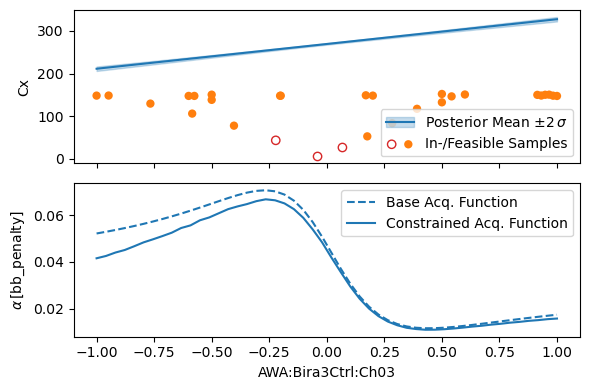

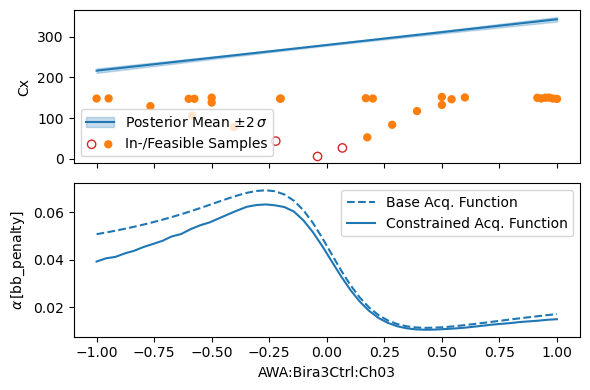

In [12]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.25},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

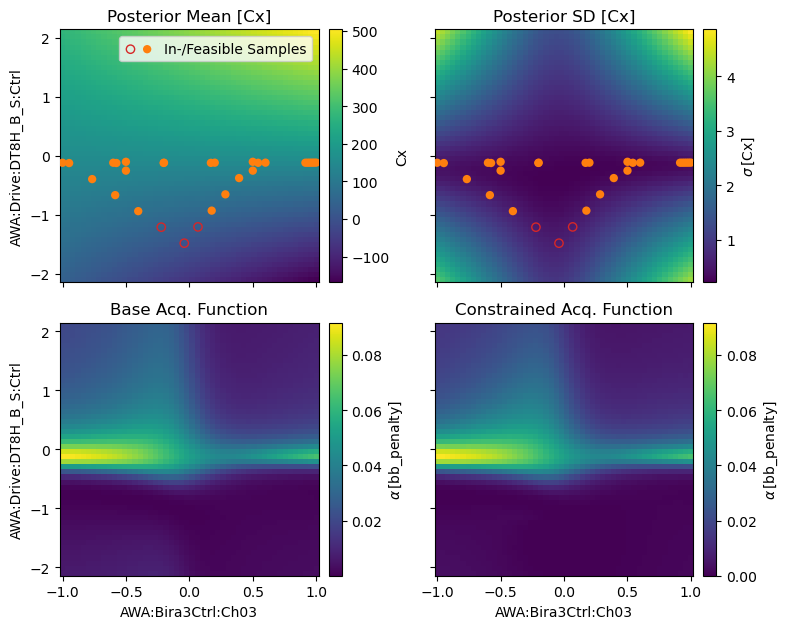

In [13]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)
